In [ ]:
import numpy as np
import pandas as pd 
import skimage.io as io
from skimage.transform import resize
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = glob.glob('/content/drive/MyDrive/pattern_project/hela/*')

In [ ]:
directory

['/content/drive/MyDrive/pattern_project/hela/actin',
 '/content/drive/MyDrive/pattern_project/hela/dna',
 '/content/drive/MyDrive/pattern_project/hela/endosome',
 '/content/drive/MyDrive/pattern_project/hela/er',
 '/content/drive/MyDrive/pattern_project/hela/golgia',
 '/content/drive/MyDrive/pattern_project/hela/golgpp',
 '/content/drive/MyDrive/pattern_project/hela/lysosome',
 '/content/drive/MyDrive/pattern_project/hela/microtubules',
 '/content/drive/MyDrive/pattern_project/hela/mitochondria',
 '/content/drive/MyDrive/pattern_project/hela/nucleolus']

In [ ]:
directory = [i + "/*" for i in directory]
directory = [glob.glob(i) for i in directory]

In [ ]:
img_dir = np.array([])

for i in directory:
  img_dir = np.concatenate((img_dir, i), axis = 0)

In [ ]:
img_dir[0].endswith(('.tif', '.TIF'))

True

In [ ]:
img_dir[0].split('/')[-1].split('_')[0]

'actin'

In [ ]:
labels = []
images = []

for i in img_dir: 
  if i.endswith(('.tif', '.TIF')):
    #images.append(io.imread(i))
    images.append(np.round(resize(io.imread(i), (332, 332), anti_aliasing=True, preserve_range=True)).astype(int))
    labels.append(i.split('/')[-1].split('_')[0])


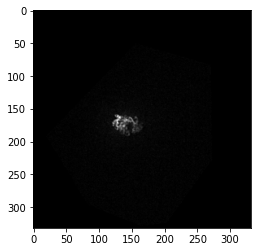

In [ ]:
plt.imshow(images[400], cmap='gray')

In [ ]:
len(np.unique(labels, axis=0))

10

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
lb = LabelEncoder()
y = lb.fit_transform(labels)

In [ ]:
x = np.array(images)

In [ ]:
x.shape

(862, 332, 332)

In [ ]:
import albumentations as A

In [ ]:
transform = A.Compose([
    A.RandomCrop(width=x[0].shape[0]-50, height=x[0].shape[0]-50),
    A.augmentations.transforms.Flip(),
    A.RandomBrightnessContrast(p=0.2),
    A.augmentations.transforms.Blur(blur_limit=8),
    A.augmentations.transforms.GaussNoise()
])

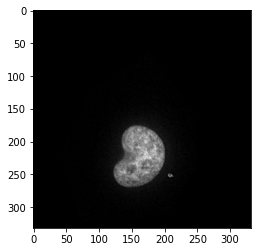

In [ ]:
plt.imshow(images[120], cmap='gray')

In [ ]:
transformed_image_1 = transform(image=x[120])['image']
transformed_image_2 = transform(image=x[120])['image']
transformed_image_3 = transform(image=x[120])['image']

In [ ]:
transformed_image_1.shape

(282, 282)

In [ ]:
x_aug = []
y_aug = []

for i in range(len(x)):
  x_aug.append(np.round((resize(x[i], (x[0].shape[0]-50, x[0].shape[0]-50), anti_aliasing=True, preserve_range=True))).astype(int))
  y_aug.append(y[i])

  for j in range(3):
    x_aug.append(transform(image=x[i])['image'])
    y_aug.append(y[i])

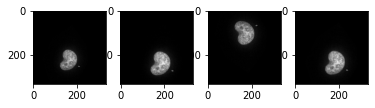

In [ ]:
plt.subplot(1, 4, 1)
plt.imshow(x_aug[480], cmap='gray')

plt.subplot(1, 4, 2)
plt.imshow(transformed_image_1, cmap='gray')

plt.subplot(1, 4, 3)
plt.imshow(transformed_image_2, cmap='gray')

plt.subplot(1, 4, 4)
plt.imshow(transformed_image_3, cmap='gray')

plt.show()

In [ ]:
np.unique(y_aug, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([87, 86, 98, 91, 87, 85, 84, 91, 73, 80]))

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([87, 86, 98, 91, 87, 85, 84, 91, 73, 80]))

In [ ]:
len(x_aug)

3448

In [ ]:
len(y)

862

In [ ]:
x_aug = np.array(x_aug)/255
y_aug = np.array(y_aug)

In [ ]:
x_new = x_aug
y_new = y_aug

In [ ]:
x_new = x_new.reshape(len(x_new), x_new.shape[1], x_new.shape[2], 1)
x_new.shape

(862, 332, 332, 1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_new, y_new, test_size = 0.15, shuffle=True, random_state=47)

In [ ]:
del x_new
del y_new

del x_aug
del y_aug

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.18, shuffle=True, random_state=47)

In [ ]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([62, 63, 62, 67, 62, 57, 56, 66, 48, 57]))

In [ ]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([13, 14, 18, 11, 11, 12, 11, 15, 14, 11]))

In [ ]:
np.unique(Y_val, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([12,  9, 18, 13, 14, 16, 17, 10, 11, 12]))

In [ ]:
from keras import layers
from keras import models
from keras import optimizers

In [ ]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Input,Lambda ,SeparableConv2D,BatchNormalization,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.utils import to_categorical 
from keras.optimizers import SGD,Adam
import tensorflow as tf

In [ ]:
X_train.shape

(600, 332, 332, 1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 330, 330, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 165, 165, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 163, 163, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 81, 81, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 79, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       7

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pattern_project/habd_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)]

In [ ]:
model.fit(X_train, Y_train, validation_data= (X_val, Y_val), epochs = 50, batch_size= 128, shuffle = True, callbacks=callbacks)

Epoch 1/50
19/19 [==============================] - 55s 449ms/step - loss: 4.3033 - accuracy: 0.1374 - val_loss: 1.9717 - val_accuracy: 0.3523

Epoch 00001: val_accuracy improved from -inf to 0.35227, saving model to /content/drive/MyDrive/pattern_project/habd_model.h5
Epoch 2/50
19/19 [==============================] - 4s 235ms/step - loss: 1.7531 - accuracy: 0.3436 - val_loss: 1.2284 - val_accuracy: 0.4848

Epoch 00002: val_accuracy improved from 0.35227 to 0.48485, saving model to /content/drive/MyDrive/pattern_project/habd_model.h5
Epoch 3/50
19/19 [==============================] - 4s 236ms/step - loss: 1.2453 - accuracy: 0.5081 - val_loss: 1.0638 - val_accuracy: 0.5625

Epoch 00003: val_accuracy improved from 0.48485 to 0.56250, saving model to /content/drive/MyDrive/pattern_project/habd_model.h5
Epoch 4/50
19/19 [==============================] - 4s 236ms/step - loss: 1.0040 - accuracy: 0.6104 - val_loss: 0.8156 - val_accuracy: 0.6837

Epoch 00004: val_accuracy improved from 0.5

In [ ]:
n_model = models.load_model('/content/drive/MyDrive/pattern_project/norm_model_val.h5')

In [ ]:
n_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 76ms/step - loss: 0.0576 - accuracy: 0.9769


[0.05755745992064476, 0.9769230484962463]

In [ ]:
n_model.evaluate(x.reshape(-1, 332, 332, 1)/255, y)

27/27 [==============================] - 42s 38ms/step - loss: 0.1146 - accuracy: 0.9710


[0.11463350057601929, 0.97099769115448]

In [ ]:
#model.save('/content/drive/MyDrive/pattern_project/norm_model_val.h5')

In [ ]:
len(X_test)/len(x)

0.15081206496519722

In [ ]:
Y_pred = np.argmax(n_model.predict(x.reshape(-1, 332, 332, 1)), axis = 1)

In [ ]:
lb.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array(['DNA', 'ER', 'actin', 'endosome', 'golgia', 'golgpp', 'lysosome',
       'microtubules', 'mitochondria', 'nucleolus'], dtype='<U12')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
confusion_matrix(Y_pred, y)

array([[86,  7,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 65,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2, 98,  2,  0,  0,  1, 28,  0,  0],
       [ 0,  0,  0, 79,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0, 38,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 19, 61,  0,  0,  0,  0],
       [ 0,  1,  0,  4,  0,  0, 76,  0,  0,  0],
       [ 0,  8,  0,  4,  0,  1,  1, 63,  0,  1],
       [ 0,  3,  0,  2,  0,  1,  1,  0, 73,  0],
       [ 0,  0,  0,  0, 30, 20,  0,  0,  0, 79]])

In [ ]:
img_dir[0]

'/content/drive/MyDrive/pattern_project/hela/actin/actin_062.tif'

In [ ]:
import pandas as pd 

In [ ]:
img_dir[0].split("/")[-1]

'actin_062.tif'

In [ ]:
image_names = np.array([i.split("/")[-1] for i in img_dir])

In [ ]:
y[1]

2

In [ ]:
image_names.shape

(862,)

In [ ]:
outputs = pd.DataFrame()
outputs["Image Name"] = image_names
outputs["Model Prediction"] = lb.inverse_transform(Y_pred)
outputs["Ground Truth"] = lb.inverse_transform(y)
outputs["Correct Classification"] = Y_pred == y

In [ ]:
outputs

,Image Name,Model Prediction,Ground Truth,Correct Classification
0,actin_062.tif,actin,actin,True
1,actin_063.tif,actin,actin,True
2,actin_001.tif,actin,actin,True
3,actin_075.tif,actin,actin,True
4,actin_002.tif,actin,actin,True
...,...,...,...,...
857,nucleolus_055.tif,nucleolus,nucleolus,True
858,nucleolus_056.tif,nucleolus,nucleolus,True
859,nucleolus_057.tif,nucleolus,nucleolus,True
860,nucleolus_058.tif,nucleolus,nucleolus,True


In [ ]:
#outputs.to_excel("outputs.xlsx", index=False)

In [ ]:
outputs['Model Prediction'].value_counts()

actin           132
nucleolus       129
DNA              93
endosome         84
lysosome         81
golgpp           80
mitochondria     80
microtubules     78
ER               65
golgia           40
Name: Model Prediction, dtype: int64

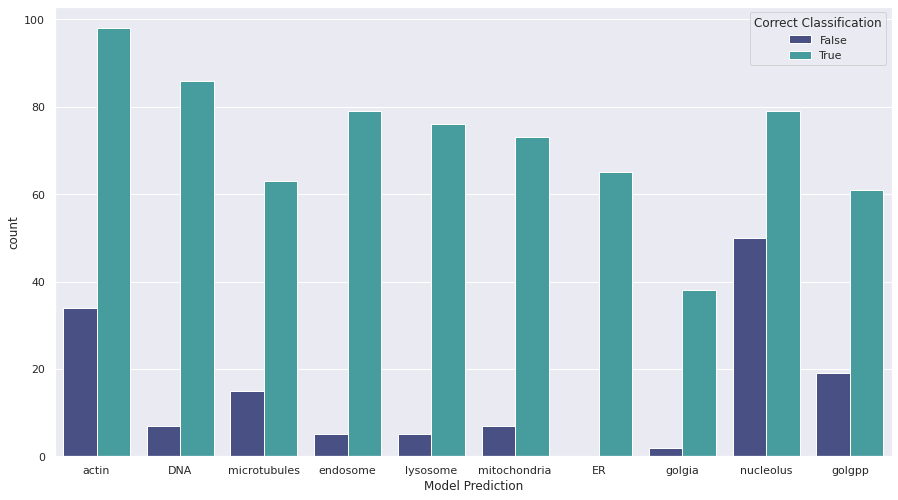

In [ ]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.countplot(x="Model Prediction", hue="Correct Classification", data=outputs, palette="mako")